We now incorporate oversampling and undersampling strategies into our supervised ML implementation. We will use `SMOTE` for oversampling and `RandomUnderSampler` for undersampling. These will be incorporated per CV split, post `StandardScaler`, but before `PCA`. In addition, we also include various methods for hyperparameter tuning, implemented per fold: `GridSearchCV`, `RandomisedSearchCV`, `BayesianSearchCV`, and `HalvingSearchCV` (this last one is experimental).

# Initial imports

In [1]:
# Data loading
import os
from glob import glob
from pathlib import Path

# Key imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Preprocessing
from sklearn.model_selection import StratifiedKFold 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Over/Undersampling (after standard scaling, before PCA)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# ML implementation
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier

# Hyperparameter tuning
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV
from skopt import BayesSearchCV

# Model evaluation
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, f1_score, recall_score,
                             classification_report, make_scorer, confusion_matrix, ConfusionMatrixDisplay)

# Using all labels

In [2]:
cwd = Path.cwd()
print(cwd)
prepped_data_dir = cwd / "PreppedData"

# If current path does not end in "PreppedData", move into it
if cwd.name != "PreppedData":
    if prepped_data_dir.exists():
        os.chdir(prepped_data_dir)
        print(f"Changed working directory to: {prepped_data_dir}")
    else:
        raise FileNotFoundError(f"'Annotations' directory not found at: {prepped_data_dir}")
else:
    print(f"Already in {cwd.name} directory.")

/home/fs1620/MLBD_2024_25/Research_Project/LiaDataAnalysis/SupervisedML_v3
Changed working directory to: /home/fs1620/MLBD_2024_25/Research_Project/LiaDataAnalysis/SupervisedML_v3/PreppedData


In [3]:
# Load data, display relevant summary stats
n_split = 5
shuffle = True
random_state = 42

data = np.load('combined_logmed_transformed.npz')
X = data['X']
y = data['y']

print('X:')
display(X)
print('\nClass counts:', Counter(y))
print('\nX shape:', X.shape, 'y shape:', y.shape)
print('\nUnique class labels:', np.unique(y))

X:


array([[-0.00021589, -0.00021589, -0.00021589, ..., -0.00021589,
        -0.00021589, -0.00021589],
       [-0.00021602, -0.00021602, -0.00021602, ..., -0.00021602,
        -0.00021602, -0.00021602],
       [-0.00023529, -0.00023529, -0.00023529, ..., -0.00023529,
        -0.00023529, -0.00023529],
       ...,
       [-0.00026413, -0.00026413, -0.00026413, ..., -0.00018941,
        -0.00026413, -0.00026413],
       [-0.00026318, -0.00026318, -0.00026318, ..., -0.0001802 ,
        -0.00026318, -0.00026318],
       [-0.00025636, -0.00025636, -0.00025636, ..., -0.00025636,
        -0.00025636, -0.00025636]])


Class counts: Counter({np.int64(0): 1637, np.int64(1): 895, np.int64(2): 363, np.int64(4): 97, np.int64(3): 73})

X shape: (3065, 2947) y shape: (3065,)

Unique class labels: [0 1 2 3 4]


In [4]:
# Perfom stratified sampling
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds = []
for i, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    folds.append({'fold': i+1, 'train_idx': train_idx, 'val_idx': val_idx})

for fold in folds:
    train_idx = fold['train_idx']
    val_idx = fold['val_idx']
    print(len(train_idx))
    print(len(val_idx))
    
    # Check if train and val indices overlap
    overlap = set(train_idx).intersection(val_idx)
    if len(overlap) > 0:
        print(f"Warning: Overlap found in fold {fold['fold']} indices: {overlap}")
    else:
        print(f"No overlap in fold {fold['fold']} indices.")

2452
613
No overlap in fold 1 indices.
2452
613
No overlap in fold 2 indices.
2452
613
No overlap in fold 3 indices.
2452
613
No overlap in fold 4 indices.
2452
613
No overlap in fold 5 indices.


In [6]:
def svm_v3(folds, X, y, verbose = 0,
              scoring_fns = None, use_shuffled_labels = False, use_stdscale = True,
              use_pca = True, pca_variance = 0.95, plot_cm_final = True, dummy = False,
              oversample=False, undersample=False,
              tune_method = None, param_grid = None, n_iter = 10, tuning_metric = 'accuracy'):
    """
    Evaluate SVM (and optionally a Dummy Classifier) on cross-validation folds, 
    with optional standardisation, PCA, over/undersampling, and per-fold hyperparameter tuning.

    Parameters
    ----------
    folds : list of dict
        List of CV splits. Each dict should contain:
        - 'fold': int (used for seeding randomness)
        - 'train_idx': indices for the training set
        - 'val_idx': indices for the validation set

    X : np.ndarray
        Feature matrix of shape (n_samples, n_features).

    y : np.ndarray
        Label vector of shape (n_samples,).

    verbose : int, default=0
        Verbosity level:
        - 0: Only final summary metrics
        - 1: Per-fold metrics
        - 2: Additional PCA info (e.g., number of components, explained variance)

    scoring_fns : dict of str -> callable, optional
        Custom scoring functions. Each function should take (y_true, y_pred) and return a score.
        Example: {"f1": f1_score, "roc": roc_auc_score}

    use_shuffled_labels : bool, default=False
        If True, shuffle labels in the training data (for diagnostic/random baseline testing).

    use_stdscale : bool, default=True
        If True, standardise features using StandardScaler.

    use_pca : bool, default=True
        If True, apply PCA to reduce dimensionality before classification.

    pca_variance : float or int, default=0.95
        - If float in (0, 1], retain enough components to preserve this proportion of variance.
        - If int ≥ 1, retain exactly this many components.

    plot_cm_final : bool, default=True
        If True, plot the averaged confusion matrix over all CV folds.

    dummy : bool, default=True
        If True, fit and evaluate a DummyClassifier as a baseline.

    oversample : bool, default=False
        If True, apply SMOTE oversampling to the training data per fold.

    undersample : bool, default=False
        If True, apply RandomUnderSampler to the training data per fold.

    tune_method : str or None, default=None
        If provided, enables hyperparameter tuning using one of:
        - 'grid': GridSearchCV
        - 'random': RandomizedSearchCV
        - 'halving': HalvingGridSearchCV
        - 'bayes': BayesSearchCV (via `skopt`)

    param_grid : dict, optional
        Parameter search space for the tuning method.
        Format:
        - For 'grid' or 'halving': each value should be a list of discrete options.
        - For 'random': values can be distributions or lists.
        - For 'bayes': values should follow skopt's format, e.g., (1e-3, 1e3, 'log-uniform').

    n_iter : int, default=10
        Number of parameter settings sampled in 'random' or 'bayes' search.
        Ignored if `tune_method` is 'grid' or 'halving'.
    
    tuning_metric : str, default='accuracy'
        Scoring metric to optimise during hyperparameter tuning. Must be a valid string accepted by 
        scikit-learn's `GridSearchCV`, `RandomizedSearchCV`, `HalvingGridSearchCV`, or `BayesSearchCV`.
        Examples include:
        - 'accuracy'
        - 'balanced_accuracy'
        - 'f1_macro'
        - 'roc_auc_ovr' (for multi-class ROC AUC)
        - 'neg_log_loss', etc.
    
        Ignored if `tune_method` is None.

    Returns
    -------
    dict
        Dictionary containing:
        - "svm_scores": dict of list of scores for each scoring metric
        - "dummy_scores": dict of list of scores (if dummy=True), else None
        - "all_y_true": concatenated true labels across all folds
        - "all_y_pred": predicted labels across all folds
        - "cms": list of confusion matrices (one per fold)
    """

    
    if not isinstance(verbose, int):
        raise TypeError("The 'verbose' parameter must be an integer: 0, 1, or 2.")

    print('Algorithm initialising...')

    if not use_stdscale and not use_pca:
        print("⚠️ Warning: Neither scaling nor PCA is applied — may affect model performance.")

    # Set default scoring functions
    if scoring_fns is None:
        scoring_fns = {
            "Accuracy": accuracy_score,
            "Balanced Accuracy": balanced_accuracy_score,
            "F1 (macro)": lambda y_true, y_pred: f1_score(y_true, y_pred, average='macro')
        }

    # Score containers
    svm_scores = {name: [] for name in scoring_fns}
    dummy_scores = {name: [] for name in scoring_fns} if dummy else None
    cms = []

    unique_labels = np.unique(y)
    all_y_true = []
    all_y_pred = []

    for fold in folds:
        train_idx = fold['train_idx']
        val_idx = fold['val_idx']

        X_train = X[train_idx]
        X_val = X[val_idx]
        y_train = y[train_idx]
        y_val = y[val_idx]

        if use_shuffled_labels:
            rng = np.random.default_rng(seed=fold['fold'])
            y_train = rng.permutation(y_train)

        if verbose >= 1:
            print(f"\nFold {fold['fold']}")
            print(" Train label distribution:", Counter(y_train))
            print(" Val label distribution:  ", Counter(y_val))

        if use_stdscale:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_val = scaler.transform(X_val)

        if oversample or undersample:
            sampler_steps = []
        
            if undersample:
                # Under-sample majority classes to balance with minorities
                sampler_steps.append(('under', RandomUnderSampler(sampling_strategy='auto', random_state=fold['fold'])))
        
            if oversample:
                # SMOTE only works when each class has at least k_neighbors + 1 samples
                counts = Counter(y_train)
                if any(v <= 5 for v in counts.values()):
                    print(f"⚠️ SMOTE skipped on Fold {fold['fold']} due to small class size")
                else:
                    sampler_steps.append(('smote', SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=fold['fold'])))
        
            if sampler_steps:
                sampling_pipeline = ImbPipeline(sampler_steps)
                try:
                    X_train, y_train = sampling_pipeline.fit_resample(X_train, y_train)
                except ValueError as e:
                    print(f"Resampling failed on Fold {fold['fold']}: {e}")
                    continue  # optionally skip this fold

        if use_pca:
            if isinstance(pca_variance, float):
                if not (0 < pca_variance <= 1):
                    raise ValueError("If float, pca_variance must be between 0 and 1.")
            elif isinstance(pca_variance, int):
                if pca_variance <= 0:
                    raise ValueError("If int, pca_variance must be a positive integer.")
            else:
                raise TypeError("pca_variance must be a positive float (0 < val ≤ 1) or a positive int.")
        
            pca = PCA(n_components=pca_variance)
            X_train = pca.fit_transform(X_train)
            X_val = pca.transform(X_val)
        
            if verbose == 2:
                print(f"PCA components: {pca.n_components_}, explained variance: {np.sum(pca.explained_variance_ratio_):.4f}")

        if verbose == 2 and X_train.shape[1] >= 2:
            plt.figure(figsize=(6, 4))
            scatter = plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='tab10', alpha=0.6)
            plt.title(f'PCA Projection (Fold {fold["fold"]})')
            plt.xlabel("PC1")
            plt.ylabel("PC2")
            plt.colorbar(scatter, label="Class")
            plt.tight_layout()
            plt.show()
            plt.close()

        # Dummy Classifier
        if dummy:
            dummy_model = DummyClassifier(strategy='most_frequent')
            dummy_model.fit(X_train, y_train)
            y_dummy = dummy_model.predict(X_val)
            for name, fn in scoring_fns.items():
                try:
                    score = fn(y_val, y_dummy)
                    dummy_scores[name].append(score)
                except Exception as e:
                    print(f"[Dummy] {name} failed: {e}")

        # Base model
        base_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=fold['fold'], class_weight = 'balanced')
        
        # Hyperparameter tuning
        if tune_method is not None and param_grid is None:
            raise ValueError("You must provide a param_grid for hyperparameter tuning.")

        if tune_method is not None and param_grid is not None:
            if tune_method == 'grid':
                searcher = GridSearchCV(base_model, param_grid, scoring=tuning_metric, cv=3, n_jobs=-1)
            elif tune_method == 'random':
                searcher = RandomizedSearchCV(base_model, param_distributions=param_grid, n_iter=n_iter, scoring=tuning_metric , cv=3, n_jobs=-1, random_state=fold['fold'])
            elif tune_method == 'halving':
                searcher = HalvingGridSearchCV(base_model, param_grid, scoring=tuning_metric, cv=3, factor=2)
            elif tune_method == 'bayes':
                searcher = BayesSearchCV(base_model, search_spaces=param_grid, n_iter=n_iter, scoring=tuning_metric, cv=3, n_jobs=-1, random_state=fold['fold'])
            else:
                raise ValueError(f"Unknown tuning method: {tune_method}")

            if verbose >= 1:
                print(f'Tuning hyperparameters using method: {tune_method}')
                
            searcher.fit(X_train, y_train)
            svm = searcher.best_estimator_
            
            if verbose >= 1:
                print(f"Best hyperparameters (fold {fold['fold']}): {searcher.best_params_}")
                
            y_pred = svm.predict(X_val)
            
        else:
            svm = base_model
            svm.fit(X_train, y_train)
            y_pred = svm.predict(X_val)

        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)

        if verbose >= 1:
            print("\nClassification Report:")
            print(classification_report(y_val, y_pred, labels=unique_labels, zero_division=0))

        for name, fn in scoring_fns.items():
            try:
                score = fn(y_val, y_pred)
                svm_scores[name].append(score)
                if verbose >= 1:
                    print(f"{name}: {score:.4f}")
            except Exception as e:
                print(f"[SVM] {name} failed: {e}")
        
        cm = confusion_matrix(y_val, y_pred, labels=unique_labels)
        cms.append(cm)
        if verbose >= 1:
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
            fig, ax = plt.subplots(figsize=(6, 5))
            disp.plot(ax=ax, cmap='Blues', colorbar=False)
            ax.set_title(f'Confusion Matrix (Fold {fold["fold"]})')
            plt.tight_layout()
            plt.show()
            plt.close()

    # Average confusion matrix
    if plot_cm_final and cms:
        avg_cm = np.mean(cms, axis=0)
        plt.figure(figsize=(7, 6))
        sns.heatmap(avg_cm, annot=True, fmt=".1f", cmap="Blues",
                    xticklabels=unique_labels, yticklabels=unique_labels)
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.title('Average Confusion Matrix Across Folds')
        plt.tight_layout()
        plt.savefig("Average_Confusion_Matrix.png", dpi=300)
        plt.show()
        plt.close()

    # Summary
    if verbose >= 0:
        print("\n=== Summary ===")
        if dummy:
            for name, scores in dummy_scores.items():
                scores = np.array(scores)
                print(f"Dummy — {name}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")
                print('\n')
        for name, scores in svm_scores.items():
            scores = np.array(scores)
            print(f"SVM — {name}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")
    
        print("\n=== Final Averaged Classification Report Across All Folds ===")
        print(classification_report(all_y_true, all_y_pred, labels=unique_labels, zero_division = 0))

    return {"svm_scores": svm_scores, 
            "dummy_scores": dummy_scores if dummy else None,
            "all_y_true": all_y_true,
            "all_y_pred": all_y_pred,
            "cms": cms}

Algorithm initialising...


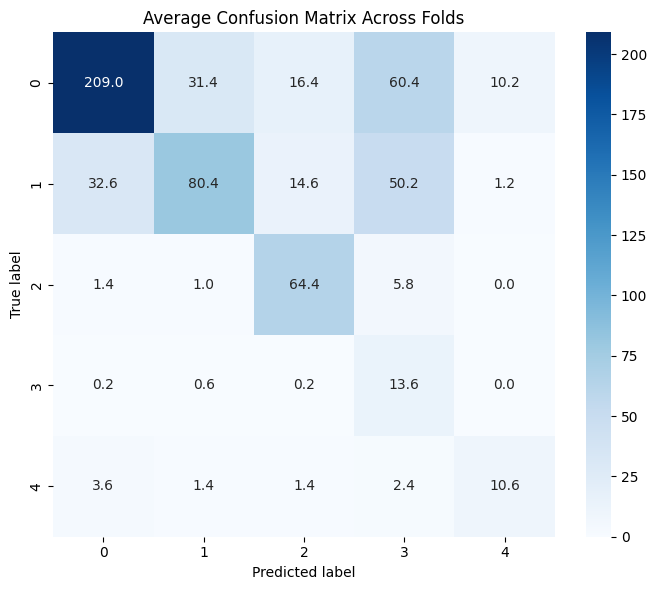


=== Summary ===
SVM — Accuracy: 0.6166 ± 0.0512
SVM — Balanced Accuracy: 0.6900 ± 0.0409
SVM — F1 Score (weighted): 0.6572 ± 0.0311
SVM — Recall (weighted): 0.6166 ± 0.0512

=== Final Averaged Classification Report Across All Folds ===
              precision    recall  f1-score   support

           0       0.85      0.64      0.73      1637
           1       0.70      0.45      0.55       895
           2       0.66      0.89      0.76       363
           3       0.10      0.93      0.19        73
           4       0.48      0.55      0.51        97

    accuracy                           0.62      3065
   macro avg       0.56      0.69      0.55      3065
weighted avg       0.75      0.62      0.66      3065



In [7]:
custom_metrics = {
    "Accuracy": accuracy_score,
    "Balanced Accuracy": balanced_accuracy_score,
    "F1 Score (weighted)": lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted'),
    "Recall (weighted)": lambda y_true, y_pred: recall_score(y_true, y_pred, average='weighted')
}

param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.01]
}

fit_all_labels = svm_v3(
    folds=folds, X=X, y=y,
    scoring_fns=custom_metrics,
    oversample=True, undersample=True,
    tune_method='grid', param_grid=param_grid,
    tuning_metric='recall_weighted'
)

# Reduced approach, excluding minority classes 3 (CGIN) & 4 (HPV INFECTION)

In [8]:
n_split = 5
shuffle = True
random_state = 42

data = np.load('combined_logmed_transformed.npz')
X = data['X']
y = data['y']

mask = (y != 3) & (y != 4)

# Apply mask to X and y
X_filtered = X[mask]
y_filtered = y[mask]

display(X_filtered)
print(Counter(y_filtered))
print(X_filtered.shape, y_filtered.shape)
print(np.unique(y_filtered))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds_red = []
for i, (train_idx_red, val_idx_red) in enumerate(skf.split(X_filtered, y_filtered)):
    folds_red.append({'fold': i+1, 'train_idx': train_idx_red, 'val_idx': val_idx_red})

array([[-0.00021589, -0.00021589, -0.00021589, ..., -0.00021589,
        -0.00021589, -0.00021589],
       [-0.00021602, -0.00021602, -0.00021602, ..., -0.00021602,
        -0.00021602, -0.00021602],
       [-0.00023529, -0.00023529, -0.00023529, ..., -0.00023529,
        -0.00023529, -0.00023529],
       ...,
       [-0.00026413, -0.00026413, -0.00026413, ..., -0.00018941,
        -0.00026413, -0.00026413],
       [-0.00026318, -0.00026318, -0.00026318, ..., -0.0001802 ,
        -0.00026318, -0.00026318],
       [-0.00025636, -0.00025636, -0.00025636, ..., -0.00025636,
        -0.00025636, -0.00025636]])

Counter({np.int64(0): 1637, np.int64(1): 895, np.int64(2): 363})
(2895, 2947) (2895,)
[0 1 2]


Algorithm initialising...


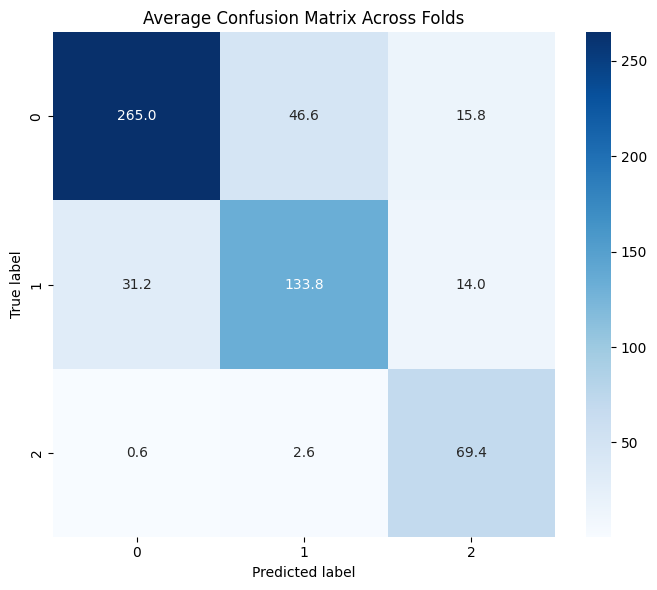


=== Summary ===
SVM — Accuracy: 0.8086 ± 0.0074
SVM — Balanced Accuracy: 0.8376 ± 0.0084
SVM — F1 Score (weighted): 0.8099 ± 0.0072
SVM — Recall (weighted): 0.8086 ± 0.0074

=== Final Averaged Classification Report Across All Folds ===
              precision    recall  f1-score   support

           0       0.89      0.81      0.85      1637
           1       0.73      0.75      0.74       895
           2       0.70      0.96      0.81       363

    accuracy                           0.81      2895
   macro avg       0.77      0.84      0.80      2895
weighted avg       0.82      0.81      0.81      2895



In [9]:
custom_metrics = {
    "Accuracy": accuracy_score,
    "Balanced Accuracy": balanced_accuracy_score,
    "F1 Score (weighted)": lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted'),
    "Recall (weighted)": lambda y_true, y_pred: recall_score(y_true, y_pred, average='weighted')
}

param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.01]
}

fit_red_labels = svm_v3(folds = folds_red, X = X_filtered, y = y_filtered, scoring_fns = custom_metrics,
                           oversample = True, undersample = True,
                           tune_method = 'grid', param_grid = param_grid, tuning_metric = 'recall_weighted')